Who Do I Talk To?

Using Natural Language Processing to Recommend Therapists

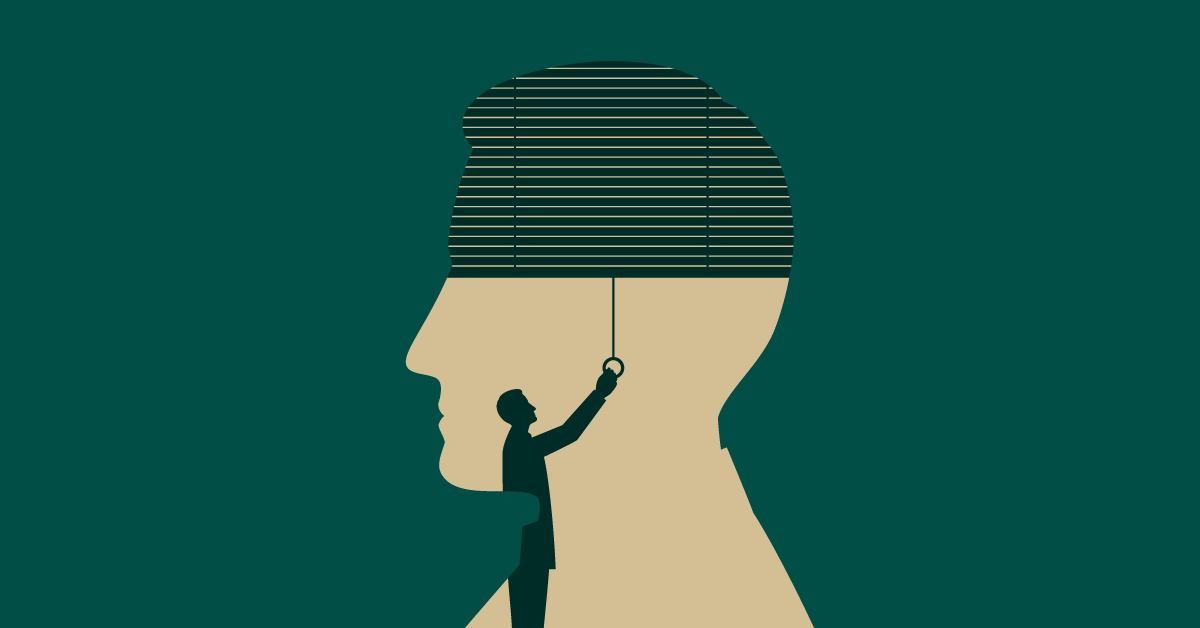

## Data Collection

Profile data for 4062 therapists in the Denver Metro Area from GoodTherapy.com. Each profile contains a section where the therapist can describe their approach and their practice. This is the section is outlined in red below and is the focus for this project.

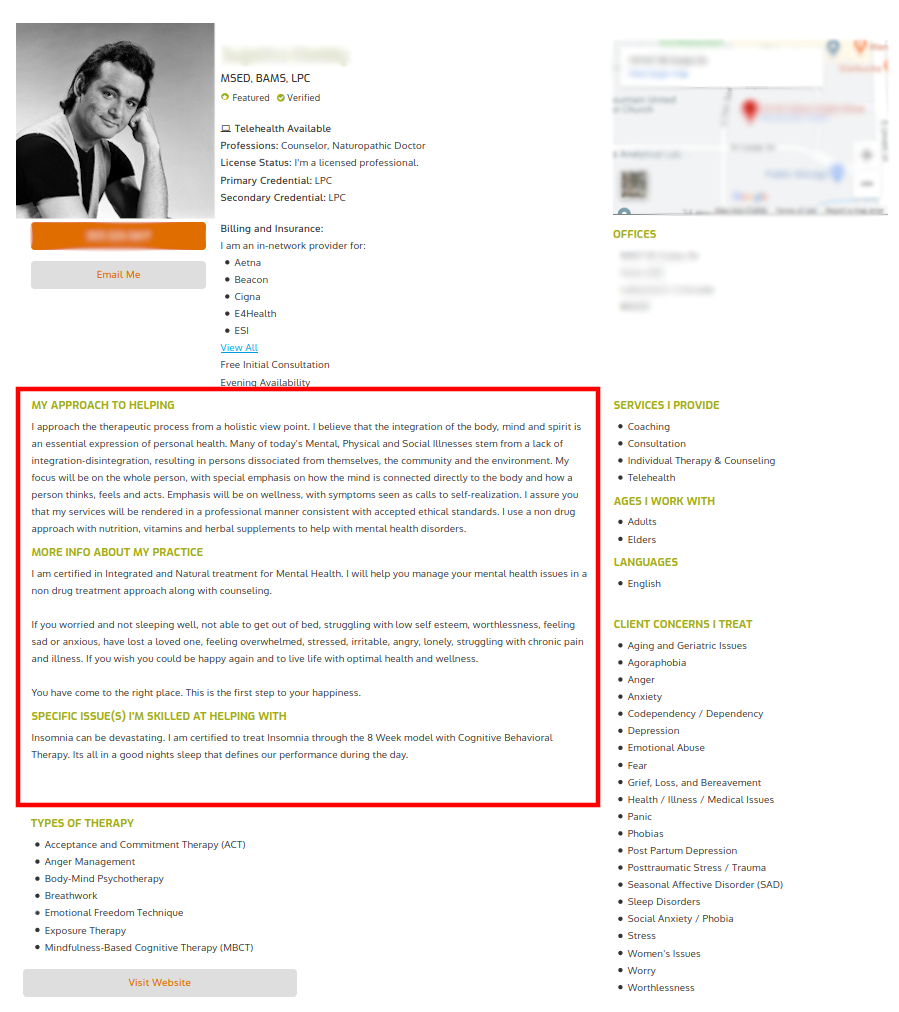

In [12]:
!pip install -q watermark

In [44]:
import os
import re
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

In [ ]:
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina' #'svg'
%reload_ext google.colab.data_table

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

%reload_ext watermark
%watermark -m -iv

seed = 13
random.seed(seed)
np.random.seed(seed)

In [45]:
def dec_check_none(func):
        def func_wrapper(*args, **kwargs):
            try:
                val = func(*args, **kwargs)
                return val
            except Exception as e:
                if isinstance(e, AttributeError):
                    return None
        return func_wrapper

class GoodTherapySoupScraper(object):
    
    def __init__(self, starting_url):
        self.starting_url = starting_url
        self.escape_chars = ['/','\n','/n','\r', '\t']

    def get_soup(self):
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        page = requests.get(self.starting_url, headers=headers)
        soup = BeautifulSoup(page.content, 'html.parser')
        soup.prettify()
        return soup

    def clean_string(self, string: str) -> str:
        string = self.clean_escapes(string)
        #string = clean_punctuation(string)
        
        return string.strip()

    def clean_escapes(self, string: str):
        for esc in self.escape_chars:
            string = string.replace(esc,'')
            #string = string.replace('/n','')
            #string = string.replace('\n','')
            #string = string.replace('\r','')

        return string

    def clean_punctuation(self, string: str, keep_emo_punc=False) -> str:
        string = string.replace('&amp;', '&')

    def convert_html_list(self, li: list):
        clean_li = []
        for elem in li:
            if elem not in self.escape_chars:
                try:
                    string = ''
                    if isinstance(elem, str):
                        string = elem.strip()
                    else:
                        string = elem.text.strip()
                    
                    #check if empty
                    if string:
                        clean_li.append(string)
                except Exception as e:
                    print(f'Error caught: {e}')
                    continue
                
        return clean_li
        #return [tag.text for tag in li if type(tag) == 'li']
        
    def get_all_data(self, soup: BeautifulSoup) -> dict:
        all_data = {}
        all_data['name'] = self.get_name(soup)
        all_data['writing_sample'] = self.get_writing_sample(soup)
        all_data['issues'] = self.get_tx_issues(soup)
        all_data['orientations'] = self.get_orientations(soup)
        all_data['services'] = self.get_services(soup)
        all_data['ages'] = self.get_client_ages(soup)
        all_data['professions'] = self.get_professions(soup)
        all_data['credential'] = self.get_primary_credential(soup)
        all_data['license_status'] = self.get_license_status(soup)
        all_data['website'] = self.get_website(soup)
        all_data['address'] = self.get_address(soup)
        all_data['phone'] = self.get_phone(soup)
        all_data['verified'] = self.get_verification(soup)
        
        return all_data

    @dec_check_none
    def get_name(self, soup: BeautifulSoup) -> str:
        name = soup.find('h1', id='profileTitle_id').contents[1].get_text()
        return self.clean_escapes(name)

    @dec_check_none
    def get_writing_sample(self, soup: BeautifulSoup) -> str:
        desc = soup.find_all('div', class_='profileBottomLeft')
        all_text = desc[0].find_all('div', class_='text')
        good_stuff = []
        for txt in all_text:
            for child in txt.children:
                if(child.name == 'p'):
                    good_stuff.append(child.get_text())

        good_stuff_st = ''.join(good_stuff)
        return good_stuff_st

    @dec_check_none
    def get_tx_issues(self, soup: BeautifulSoup)-> list:
        issues_html = soup.find_all('ul', id='issuesData')
        issues_list = list(issues_html[0].children)
        
        ##if want to return string instead
        # issues_str = issues_html[0].get_text()
        # clean_str = clean_string(issues_str)
        list_text = self.convert_html_list(issues_list)
        return list_text

    @dec_check_none
    def get_orientations(self, soup: BeautifulSoup)-> list:
        orientations_html = soup.find_all('ul', id='modelsData')
        orientations_list = list(orientations_html[0].children)
        
        ##if want to return string instead
        # issues_str = issues_html[0].get_text()
        # clean_str = clean_string(issues_str)
        list_text = self.convert_html_list(orientations_list)
        return list_text

    @dec_check_none
    def get_services(self, soup: BeautifulSoup)-> list:
        services_html = soup.find_all('ul', id='servicesprovidedData')
        services_list = list(services_html[0].children)
        
        list_text = self.convert_html_list(services_list)
        return list_text

    @dec_check_none
    def get_client_ages(self, soup: BeautifulSoup) -> list:
        ages_html = soup.find_all('ul', id='agesData')
        ages_list = list(ages_html[0].children)
        
        list_text = self.convert_html_list(ages_list)
        return list_text

    @dec_check_none
    def get_professions(self, soup: BeautifulSoup) -> list:
        profs_str = soup.find('span', id='professionsDefined').get_text()
        profs_list = profs_str.split(',')
        
        return [prof.strip() for prof in profs_list]

    @dec_check_none
    def get_primary_credential(self, soup: BeautifulSoup) -> str:
        credential = soup.find('span', id='licenceinfo1').get_text()
        
        return self.clean_escapes(credential)

    @dec_check_none
    def get_license_status(self, soup: BeautifulSoup) -> str:
        license_status = soup.find('span', id='license_status_id').get_text()
        
        return self.clean_escapes(license_status)

    @dec_check_none
    def get_website(self, soup: BeautifulSoup) -> str:
        try:
            website = soup.find('a', id='edit_website')['href']
        except:
            website = 'None'
        return website

    def get_address(self, soup: BeautifulSoup) -> dict:
        #office = soup.find('div', id='editOffice1')
        address = {}
        
        address['street'] = self.sub_get_street(soup)
        address['city'] = self.sub_get_city(soup)
        address['state'] = self.sub_get_state(soup)
        address['zip'] = self.sub_get_zip(soup)
        
        return address

    @dec_check_none
    def sub_get_street(self, soup: BeautifulSoup) -> str:
            return soup.find('span', itemprop='streetAddress').get_text()

    @dec_check_none      
    def sub_get_city(self, soup: BeautifulSoup) -> str:
        return soup.find('span', itemprop='addressLocality').get_text()

    @dec_check_none
    def sub_get_state(self, soup: BeautifulSoup) -> str:
        return soup.find('span', itemprop='addressRegion').get_text()

    @dec_check_none            
    def sub_get_zip(self, soup: BeautifulSoup) -> str:
        return soup.find('span', itemprop='postalCode').get_text()

    @dec_check_none
    def get_phone(self, soup: BeautifulSoup) -> str:
        phone  =soup.find('span', {'class':'profilePhone'}).text
        #phone = soup.find('span', class='profilePhone').contents[1].contents[0].get_text()

        return self.clean_string(phone)

    @dec_check_none
    def get_verification(self, soup: BeautifulSoup) -> bool:
        verified  = soup.find('div', {'class':'profileVer'}).text

        return self.clean_string(verified) == 'Verified'

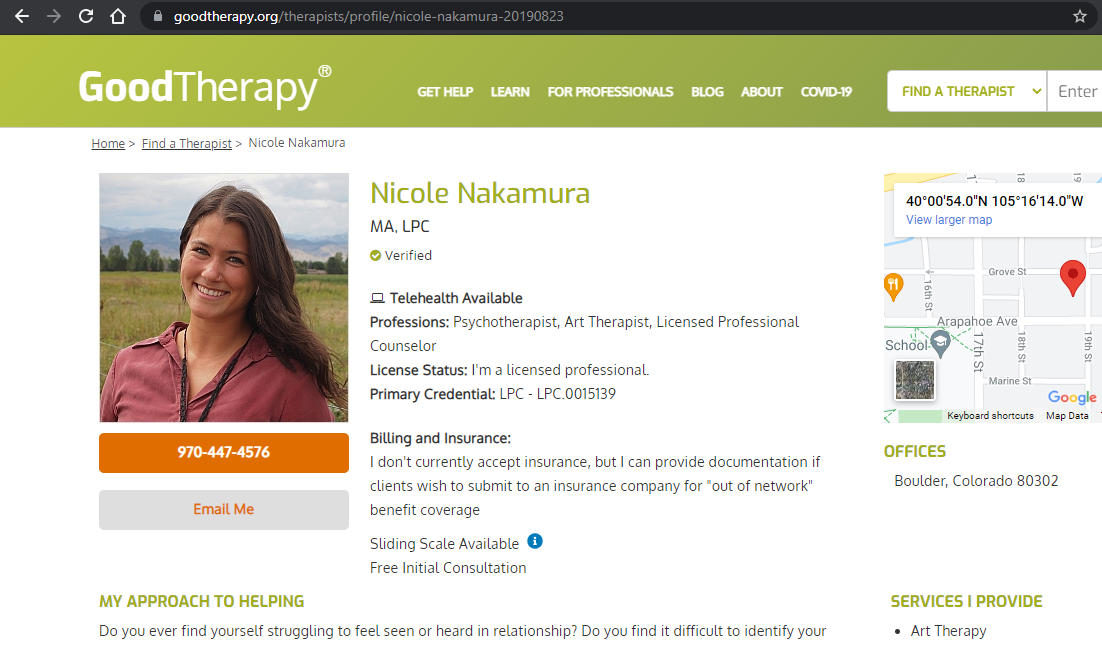

In [49]:
start_urls = 'https://www.goodtherapy.org/therapists/profile/nicole-nakamura-20190823'
good_scraper = GoodTherapySoupScraper(starting_url=start_urls)

In [50]:
soup = good_scraper.get_soup()

In [51]:
profs = good_scraper.get_professions(soup)
profs

['Psychotherapist', 'Art Therapist', 'Licensed Professional Counselor']

In [52]:
issues = good_scraper.get_tx_issues(soup)
issues

['Abuse / Abuse Survivor Issues',
 'Anxiety',
 'Attachment Issues',
 'Child and/or Adolescent Issues',
 'Depression',
 'Emotional Abuse',
 'Emotional Intelligence',
 'Emotional Overwhelm',
 'Posttraumatic Stress / Trauma',
 'Self-Confidence',
 'Sexual Assault / Abuse',
 'Shame']

In [54]:
data_dict = good_scraper.get_all_data(soup)
data_dict

{'address': {'city': 'Boulder',
  'state': 'Colorado',
  'street': None,
  'zip': '80302'},
 'ages': ['Teens', 'Adults'],
 'credential': 'LPC - LPC.0015139 ',
 'issues': ['Abuse / Abuse Survivor Issues',
  'Anxiety',
  'Attachment Issues',
  'Child and/or Adolescent Issues',
  'Depression',
  'Emotional Abuse',
  'Emotional Intelligence',
  'Emotional Overwhelm',
  'Posttraumatic Stress / Trauma',
  'Self-Confidence',
  'Sexual Assault / Abuse',
  'Shame'],
 'license_status': "I'm a licensed professional.",
 'name': 'Nicole Nakamura',
 'orientations': ['Art Therapy',
  'Focusing',
  'Relational Psychotherapy',
  'Sensorimotor Psychotherapy',
  'Transpersonal Psychotherapy'],
 'phone': '970-447-4576',
 'professions': ['Psychotherapist',
  'Art Therapist',
  'Licensed Professional Counselor'],
 'services': ['Art Therapy', 'Individual Therapy & Counseling', 'Telehealth'],
 'verified': True,
 'website': 'None',
 'writing_sample': ''}

In [55]:
for k, v in data_dict.items():
    print(f'{k.upper()} : {v}')

NAME : Nicole Nakamura
WRITING_SAMPLE : 
ISSUES : ['Abuse / Abuse Survivor Issues', 'Anxiety', 'Attachment Issues', 'Child and/or Adolescent Issues', 'Depression', 'Emotional Abuse', 'Emotional Intelligence', 'Emotional Overwhelm', 'Posttraumatic Stress / Trauma', 'Self-Confidence', 'Sexual Assault / Abuse', 'Shame']
ORIENTATIONS : ['Art Therapy', 'Focusing', 'Relational Psychotherapy', 'Sensorimotor Psychotherapy', 'Transpersonal Psychotherapy']
SERVICES : ['Art Therapy', 'Individual Therapy & Counseling', 'Telehealth']
AGES : ['Teens', 'Adults']
PROFESSIONS : ['Psychotherapist', 'Art Therapist', 'Licensed Professional Counselor']
CREDENTIAL : LPC - LPC.0015139 
LICENSE_STATUS : I'm a licensed professional.
WEBSITE : None
ADDRESS : {'street': None, 'city': 'Boulder', 'state': 'Colorado', 'zip': '80302'}
PHONE : 970-447-4576
VERIFIED : True


In [57]:
good_scraper.get_all_data(soup)

{'address': {'city': 'Boulder',
  'state': 'Colorado',
  'street': None,
  'zip': '80302'},
 'ages': ['Teens', 'Adults'],
 'credential': 'LPC - LPC.0015139 ',
 'issues': ['Abuse / Abuse Survivor Issues',
  'Anxiety',
  'Attachment Issues',
  'Child and/or Adolescent Issues',
  'Depression',
  'Emotional Abuse',
  'Emotional Intelligence',
  'Emotional Overwhelm',
  'Posttraumatic Stress / Trauma',
  'Self-Confidence',
  'Sexual Assault / Abuse',
  'Shame'],
 'license_status': "I'm a licensed professional.",
 'name': 'Nicole Nakamura',
 'orientations': ['Art Therapy',
  'Focusing',
  'Relational Psychotherapy',
  'Sensorimotor Psychotherapy',
  'Transpersonal Psychotherapy'],
 'phone': '970-447-4576',
 'professions': ['Psychotherapist',
  'Art Therapist',
  'Licensed Professional Counselor'],
 'services': ['Art Therapy', 'Individual Therapy & Counseling', 'Telehealth'],
 'verified': True,
 'website': 'None',
 'writing_sample': ''}

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `therapist_predictor` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS therapist_predictor;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE therapist_predictor;'

In [66]:
%env DATABASE_NAME=therapist_predictor
%env DATABASE_HOST=localhost
%env DATABASE_PORT=5432
%env DATABASE_USER=postgres
%env DATABASE_PASS=postgres

env: DATABASE_NAME=therapist_predictor
env: DATABASE_HOST=localhost
env: DATABASE_PORT=5432
env: DATABASE_USER=postgres
env: DATABASE_PASS=postgres


In [59]:
import psycopg2

In [68]:
conn = psycopg2.connect(dbname=os.environ['DATABASE_NAME'],
                        user=os.environ['DATABASE_USER'],
                        host=os.environ['DATABASE_HOST'],
                        password=os.environ['DATABASE_PASS'])
cur = conn.cursor()

In [70]:
start_url = 'https://www.goodtherapy.org/therapists/profile/nicole-nakamura-20190823'
good_scraper = GoodTherapySoupScraper(starting_url=start_url)
soup = good_scraper.get_soup()

all_data = good_scraper.get_all_data(soup)

#therapist_id = cur.execute("""DROP TABLE IF EXISTS quotes""")
services = good_scraper.get_services(soup)
print(all_data['full_name'])
print(all_data['first_name'])
print(all_data['last_name'])
print(all_data['phone'])

# conn.close()

KeyError: ignored

In [71]:
all_data

{'address': {'city': 'Boulder',
  'state': 'Colorado',
  'street': None,
  'zip': '80302'},
 'ages': ['Teens', 'Adults'],
 'credential': 'LPC - LPC.0015139 ',
 'issues': ['Abuse / Abuse Survivor Issues',
  'Anxiety',
  'Attachment Issues',
  'Child and/or Adolescent Issues',
  'Depression',
  'Emotional Abuse',
  'Emotional Intelligence',
  'Emotional Overwhelm',
  'Posttraumatic Stress / Trauma',
  'Self-Confidence',
  'Sexual Assault / Abuse',
  'Shame'],
 'license_status': "I'm a licensed professional.",
 'name': 'Nicole Nakamura',
 'orientations': ['Art Therapy',
  'Focusing',
  'Relational Psychotherapy',
  'Sensorimotor Psychotherapy',
  'Transpersonal Psychotherapy'],
 'phone': '970-447-4576',
 'professions': ['Psychotherapist',
  'Art Therapist',
  'Licensed Professional Counselor'],
 'services': ['Art Therapy', 'Individual Therapy & Counseling', 'Telehealth'],
 'verified': True,
 'website': 'None',
 'writing_sample': ''}